# Face Recognition System Simulation

In this document, we provide a simple simulation of a face recognition system for testing accuracy of our generator

## 1. Load everything needed

In [9]:
# System imports
import random
import sys
import os
import logging
import json
from typing import Tuple
from pathlib import Path

# Machine learning-related libraries
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.decomposition import PCA

# Graphics packages
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
pyplot.style.use('seaborn-v0_8-white') # Choose pyplot styling

# Setting float precision
np.set_printoptions(precision=3)

In [2]:
from importlib import reload
from IPython.display import display, Markdown

reload(logging)
logging.basicConfig(stream=sys.stdout, format='',
                level=logging.INFO, datefmt=None)
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def display_header(text: str) -> None:
    """
    Display a header 
    """
    display(Markdown(f'### {text}'))

In [3]:
def show_images(X: list, y: list, size: tuple = (9,9)) -> None:
    """
    Helper function displaying a set of specified images and their labels
    """
    assert len(X) == len(y), "X and y must have the same shapes"
    n = len(X)
    
    rows = int(np.sqrt(n))
    cols = n // rows
    
    fig, axs = pyplot.subplots(nrows=rows, ncols=cols, figsize=size)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(X[i], cmap=pyplot.get_cmap('gray'))
        ax.set_title(f'Number {y[i]}')
    
    fig.tight_layout()
    pyplot.show()

## 2. Import MNIST dataset and display images for debugging

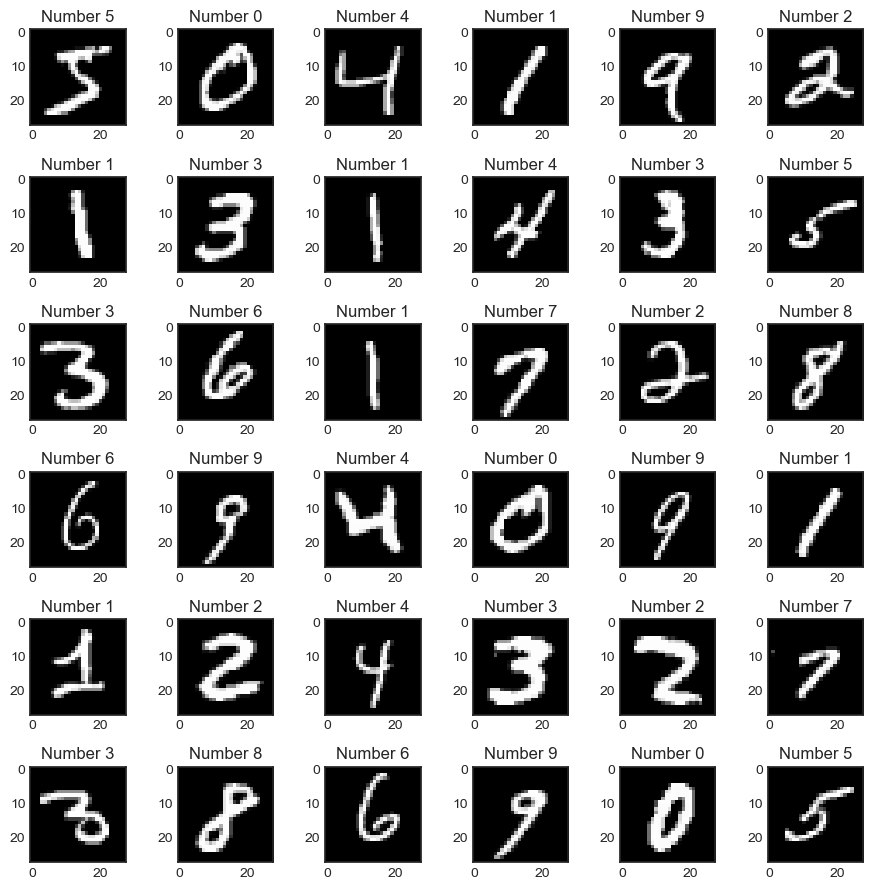

In [4]:
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X = X / 255.0
X = tf.expand_dims(X, axis=-1)

# Displaying example images
show_images(X[:36], y[:36])

# Forming batches with the same label
X_batches = [[np.array(X, dtype=np.float32) for X, y in zip(X, y) if y == digit] for digit in range(10)]

## 3. Evaluating mean-squared differences

Loading an embedding model:

In [5]:
EMBEDDING_MODEL_PATH = 'models/embedding/v1'
embedding_model = tf.keras.models.load_model(EMBEDDING_MODEL_PATH)
embedding_model._name = 'embedding'
embedding_model.trainable = False
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 2048)              1607680   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
 unit_normalization (UnitNor  (None, 10)               0         
 malization)                                                     
                                                                 
Total params: 1,628,170
Trainable params: 0
Non-trainable params: 1,628,170
_______________________________________________

Loading a generator model:

In [6]:
GENERATOR_MODEL_PATH = 'models/generator/v1.6'
generator_model = tf.keras.models.load_model(GENERATOR_MODEL_PATH)
generator_model._name = 'embedding'
generator_model.trainable = False
generator_model.summary()

Model: "embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 64)   36928       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_11[0][0]']              
                                                                                          

Generating distorted images:

In [7]:
X_generated = generator_model.predict(X, verbose=0)

2023-11-15 23:58:39.867811: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Finding mean-squared difference between true-generated images:

In [26]:
def MSEImageLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

unique_labels = np.unique(y)
X_batches_real, X_batches_generated = {}, {}
for y_unique in unique_labels:
    batch_real = np.array([X[i] for i in range(len(y)) if y[i] == y_unique])
    batch_generated = np.array([X_generated[i] for i in range(len(y)) if y[i] == y_unique])
    
    X_batches_real[y_unique] = batch_real
    X_batches_generated[y_unique] = batch_generated
    
for digit in range(10):
    loss = MSEImageLoss(X_batches_real[digit], X_batches_generated[digit])
    logging.info('Loss between real and generated digits of {} is {:.3f}'.format(digit, loss))

Loss between real and generated digits of 0 is 0.791
Loss between real and generated digits of 1 is 0.886
Loss between real and generated digits of 2 is 0.850
Loss between real and generated digits of 3 is 0.850
Loss between real and generated digits of 4 is 0.773
Loss between real and generated digits of 5 is 0.843
Loss between real and generated digits of 6 is 0.826
Loss between real and generated digits of 7 is 0.845
Loss between real and generated digits of 8 is 0.838
Loss between real and generated digits of 9 is 0.800


Defining a pair picker:

In [19]:
class PairPicker:
    """
    Class for picking the same digits
    """
    
    def __init__(self, X: list, y: list) -> None:
        """
        Initializes the PairPicker class
        
        Args:
            (X, y) - dataset
        """
        unique_labels = np.unique(y)
        self._X_batches = {}
        for y_unique in unique_labels:
            batch = [X[i] for i in range(len(y)) if y[i] == y_unique]
            self._X_batches[y_unique] = batch
        
    def pick(self, digit: int) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Picks a pair of the specified digit
        """
        digits = self._X_batches[digit]
        return random.choice(digits), random.choice(digits)
    
pair_picker_real = PairPicker(X, y)
pair_picker_generated = PairPicker(X_generated, y)

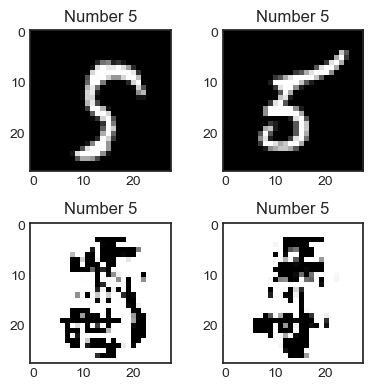

In [13]:
X1, X2 = pair_picker_real.pick(5)
X3, X4 = pair_picker_generated.pick(5)

show_images([X1, X2, X3, X4], [5]*4, size=(4,4))

In [27]:
for digit in range(10):
    avg_loss = np.mean([MSEImageLoss(*pair_picker_real.pick(digit)) for _ in range(1000)])
    logging.info('Average loss between real images of digit {} is {:.3f}'.format(digit, avg_loss))
    
for digit in range(10):
    avg_loss = np.mean([MSEImageLoss(*pair_picker_generated.pick(digit)) for _ in range(1000)])
    logging.info('Average loss between generated images of digit {} is {:.3f}'.format(digit, avg_loss))

Average loss between real images of digit 0 is 0.129
Average loss between real images of digit 1 is 0.057
Average loss between real images of digit 2 is 0.128
Average loss between real images of digit 3 is 0.113
Average loss between real images of digit 4 is 0.104
Average loss between real images of digit 5 is 0.120
Average loss between real images of digit 6 is 0.112
Average loss between real images of digit 7 is 0.096
Average loss between real images of digit 8 is 0.115
Average loss between real images of digit 9 is 0.097
Average loss between generated images of digit 0 is 0.082
Average loss between generated images of digit 1 is 0.031
Average loss between generated images of digit 2 is 0.108
Average loss between generated images of digit 3 is 0.108
Average loss between generated images of digit 4 is 0.049
Average loss between generated images of digit 5 is 0.106
Average loss between generated images of digit 6 is 0.058
Average loss between generated images of digit 7 is 0.062
Averag

### 4. Build a digit recognition system

In [9]:
X_emb = embedding_model.predict(X, verbose=0)

In [98]:
from typing import TypeAlias, Dict

UserId: TypeAlias = int

class DigitRecognitionSystem:
    """
    Mock of a face recognition system
    """
    
    LOGIN_FAILED: UserId = -1
    
    def __init__(self, generator: tf.keras.Model, embedding: tf.keras.Model, threshold: float) -> None:
        """
        Creates a simple implementation of a digit recognition system
        
        Args:
            generator - model of the generator
            threshold - threshold above which two images are considered to be different
        """
        self._threshold = threshold
        self._generator = generator
        self._embedding = embedding
        
        # Variables for storage
        self._storage: Dict[UserId, tf.Tensor] = {}
        self._last_key: UserId = 0
     
    def set_threshold(self, new_threshold: float) -> None:
        self._threshold = new_threshold
    
    def register_with_generator(self, photo: tf.Tensor) -> UserId:
        """
        Register a digit with the specified photo
        
        Args:
            photo - digit photo
            
        Returns:
            User ID assigned to the specified photo
        """
        self._last_key = self._last_key + 1
        distorted_img = self._generator(np.expand_dims(photo, axis=0))
        self._storage[self._last_key] = self._embedding(distorted_img)
        return self._last_key
        
    def register(self, photo: tf.Tensor) -> UserId:
        self._last_key = self._last_key + 1
        self._storage[self._last_key] = self._embedding(np.expand_dims(photo, axis=0))
        return self._last_key
        
    @staticmethod
    def _distance(x: tf.Tensor, y: tf.Tensor) -> float:
        """
        Finds distance between two embeddings
        """
        return tf.square(tf.norm(y - x))
    
    def login(self, photo: tf.Tensor) -> UserId:
        """
        Tries to login into the system having a photo
        """
        
        embedding_input = self._embedding(tf.expand_dims(photo, axis=0))
        return self.login_via_embedding(embedding_input)
    
    def login_via_embedding(self, photo_embedding: tf.Tensor) -> UserId:
        if np.shape(photo_embedding)[0] != 1:
            photo_embedding = tf.expand_dims(photo_embedding, axis=0)
        
        for user_id, storage_embedding in self._storage.items():
            distance = self._distance(photo_embedding, storage_embedding)
            if distance < self._threshold:
                return user_id
            
        return DigitRecognitionSystem.LOGIN_FAILED

Registered IDs are 1, 2, 3


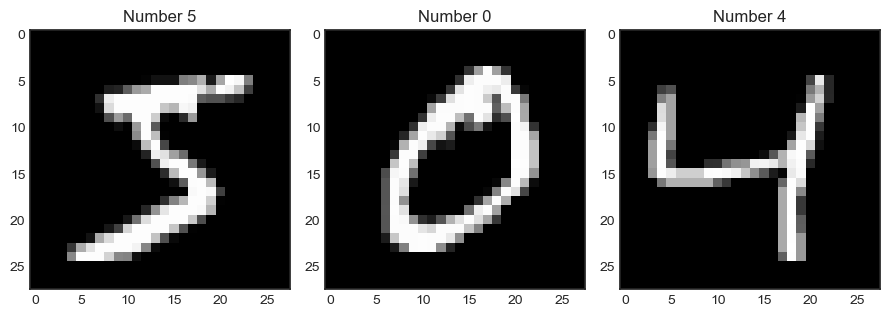

1/1 [==============================] - 0s 21ms/step


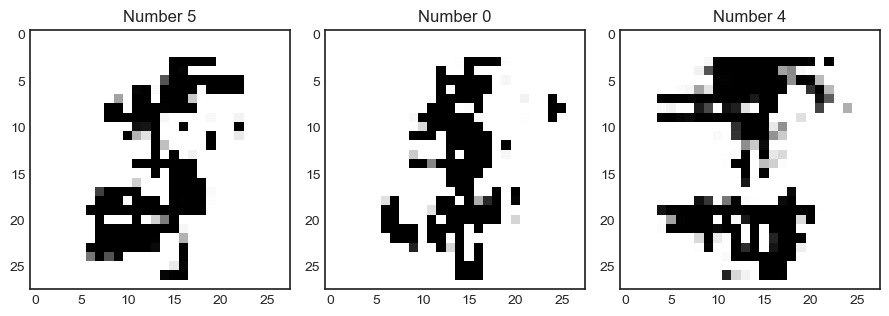

In [99]:
recognition_system = DigitRecognitionSystem(generator_model, embedding_model, 0.25)

digit_1_id = recognition_system.register_with_generator(X[0])
digit_2_id = recognition_system.register_with_generator(X[1])
digit_3_id = recognition_system.register_with_generator(X[2])

print(f'Registered IDs are {digit_1_id}, {digit_2_id}, {digit_3_id}')
show_images(X[:3], y[:3])
show_images(generator_model.predict(X[:3]), y[:3])

In [100]:
class PairValidationGenerator(tf.keras.utils.Sequence):
    def __init__(self, X: list, y: list, positive_classes=[5,0,4]) -> None:
        """
        Initializes pair generator
        """
        assert len(X) == len(y), "The number of images and labels is the same"
        
        self._positive_classes = positive_classes
        self._negative_classes = list(set(list(range(10))).difference(set(positive_classes)))

        unique_labels = np.unique(y)
        self._X_batches = {}
        for y_unique in unique_labels:
            batch = [X[i] for i in range(len(y)) if y[i] == y_unique]
            self._X_batches[y_unique] = batch
    
    def pick(self):
        """
        Generate one batch of data
        """
        
        positive_label = random.choice(self._positive_classes)
        negative_label = random.choice(self._negative_classes)
        return random.choice(self._X_batches[positive_label]), random.choice(self._X_batches[negative_label])

In [50]:
generator = PairValidationGenerator(X_emb, y, positive_classes=[5,0,4])

points = []
for threshold in np.linspace(0.0, 2.0, num=1000):
    recognition_system.set_threshold(threshold)

    # true positive, true negative, false positive, false negative
    tp = tn = fp = fn = 0

    for _ in range(1000):
        positive, negative = generator.pick()

        positive_id = recognition_system.login_via_embedding(positive)
        if positive_id == DigitRecognitionSystem.LOGIN_FAILED:
            fn += 1
        else:
            tp += 1

        negative_id = recognition_system.login_via_embedding(negative)
        if negative_id == DigitRecognitionSystem.LOGIN_FAILED:
            tn += 1
        else:
            fp += 1
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    points.append((fpr, tpr))

In [102]:
recognition_system_plain = DigitRecognitionSystem(generator_model, embedding_model, 0.25)

recognition_system_plain.register(X[0])
recognition_system_plain.register(X[1])
recognition_system_plain.register(X[2])

points_plain = []
for threshold in np.linspace(0.0, 2.0, num=1000):
    recognition_system_plain.set_threshold(threshold)

    # true positive, true negative, false positive, false negative
    tp = tn = fp = fn = 0

    for _ in range(1000):
        positive, negative = generator.pick()

        positive_id = recognition_system_plain.login_via_embedding(positive)
        if positive_id == DigitRecognitionSystem.LOGIN_FAILED:
            fn += 1
        else:
            tp += 1

        negative_id = recognition_system_plain.login_via_embedding(negative)
        if negative_id == DigitRecognitionSystem.LOGIN_FAILED:
            tn += 1
        else:
            fp += 1
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    points_plain.append((fpr, tpr))

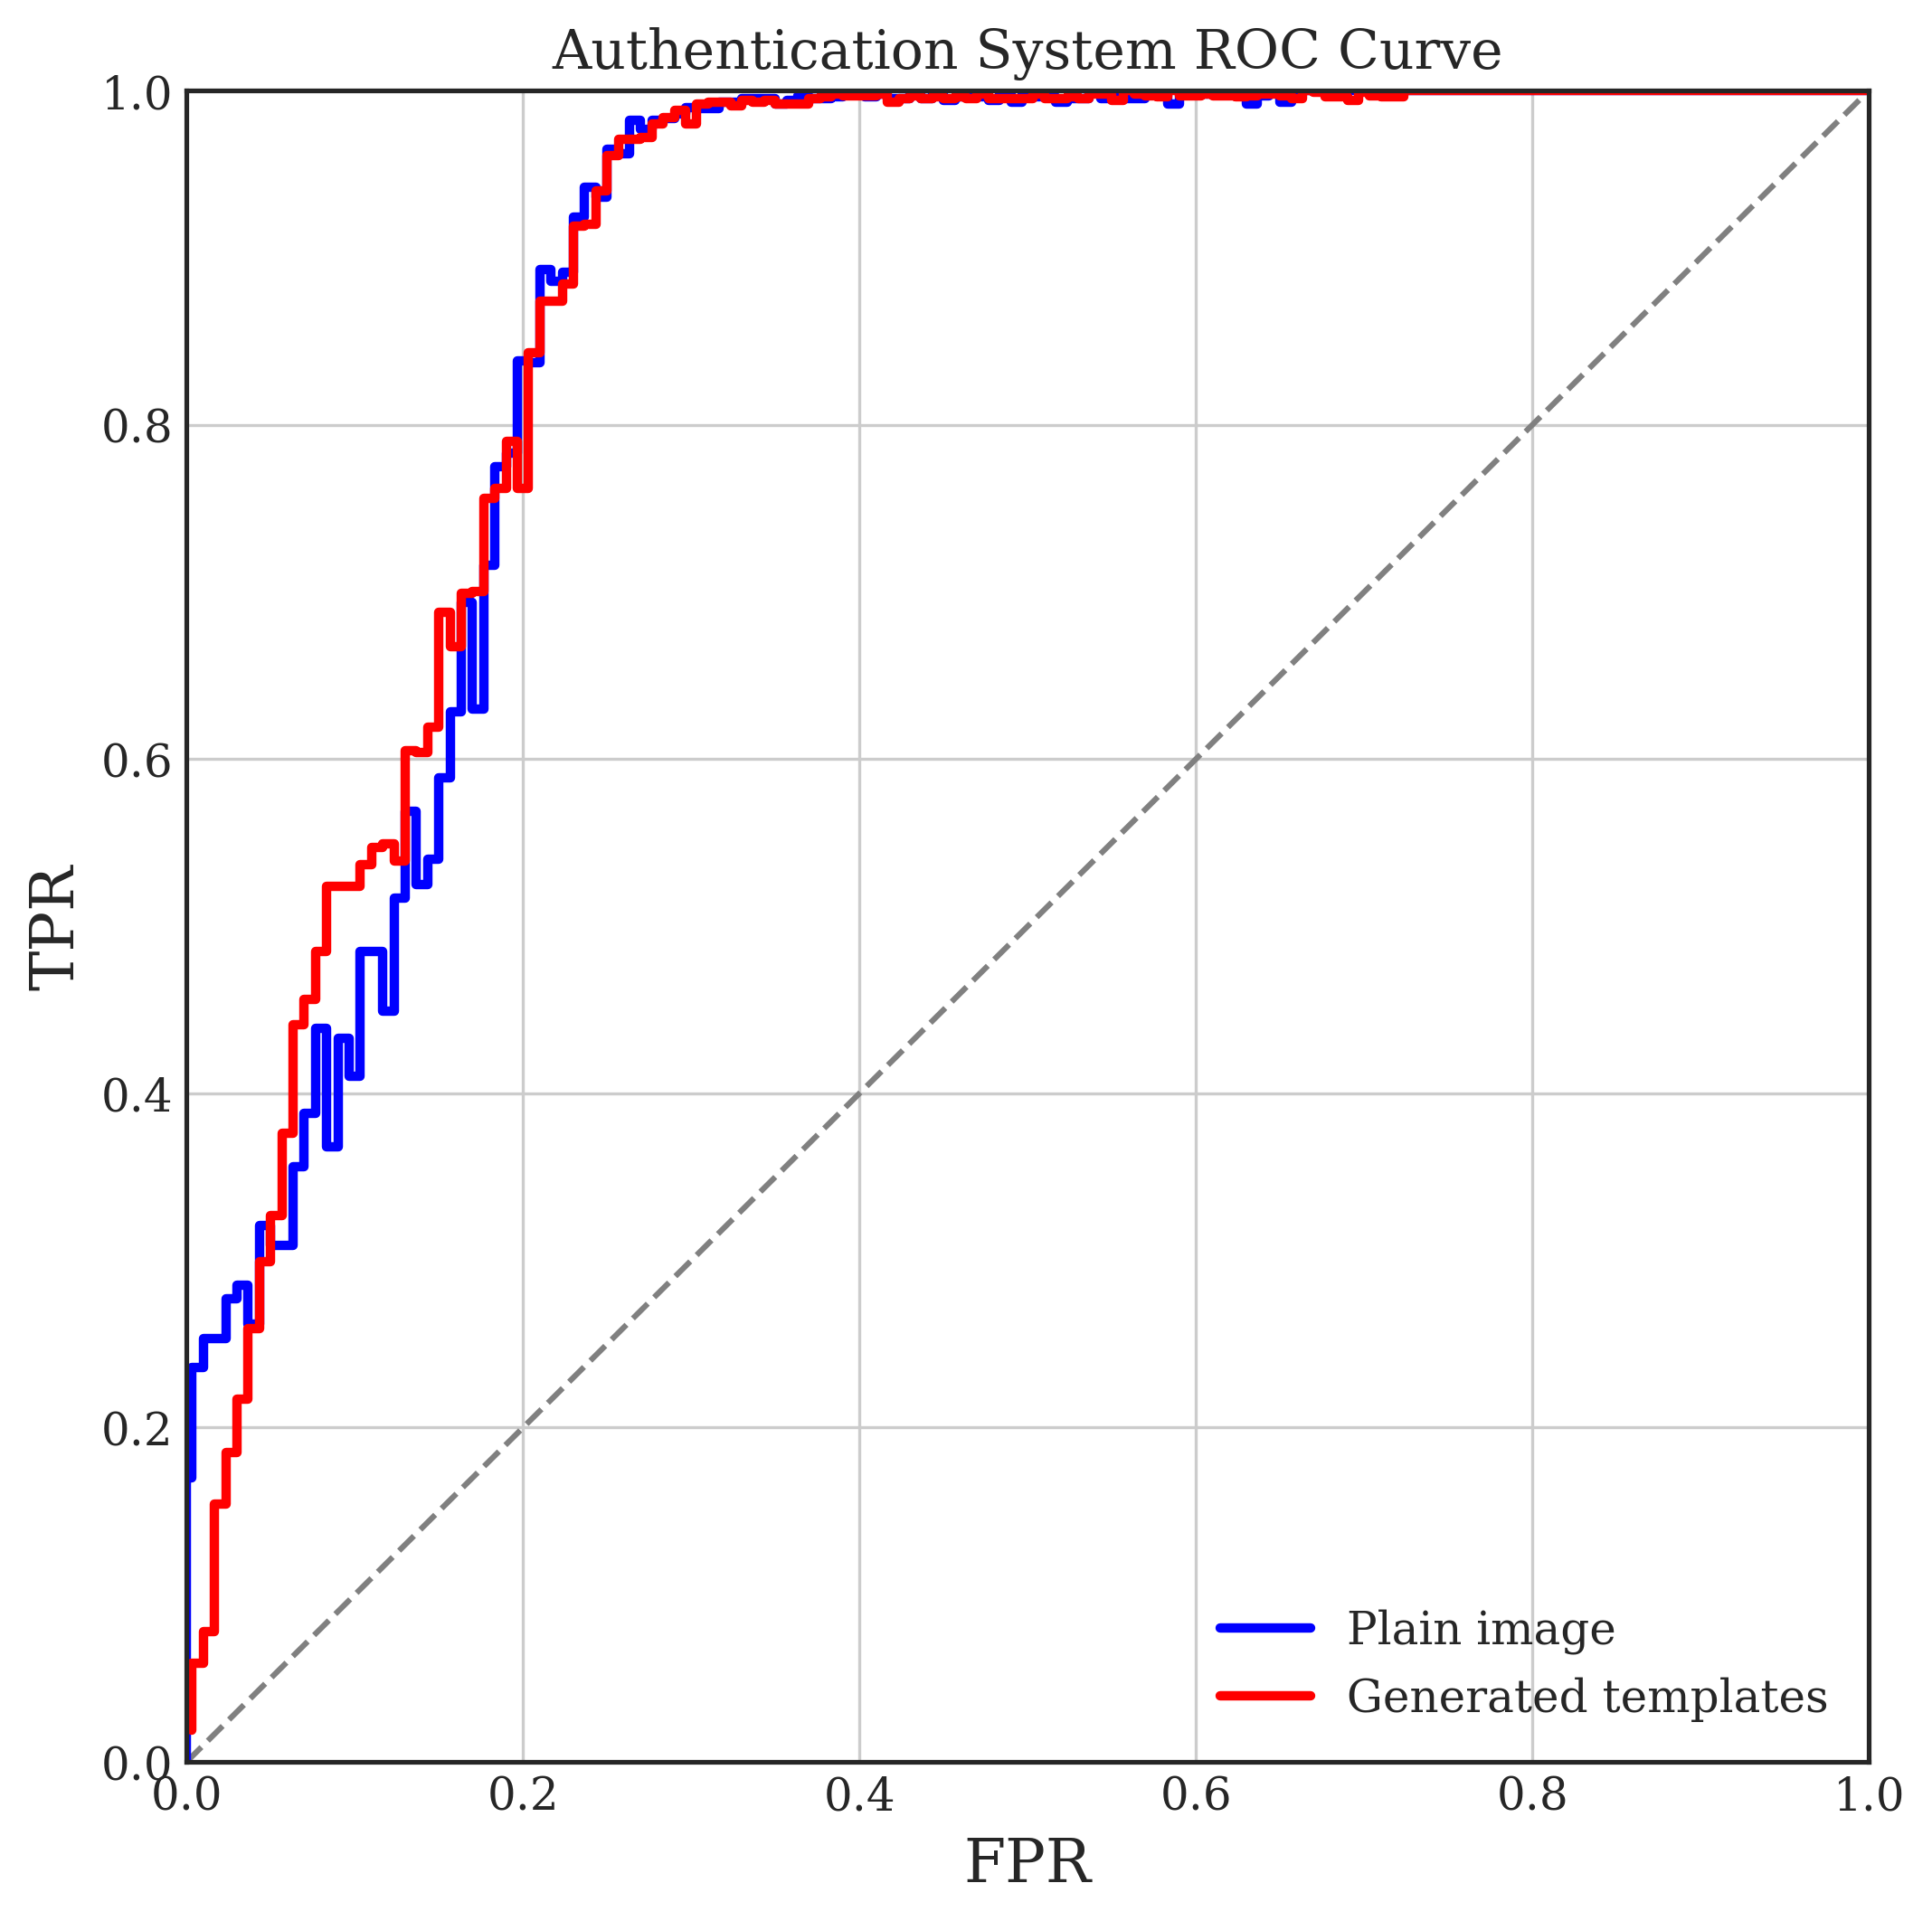

In [126]:
new_points, new_points_plain = [], []
n_split = 300
for i in range(n_split):
    a = 2.0 * i / n_split
    b = 2.0 * (i+1) / n_split
    x_point = (a + b) / 2.0
    y_interval = [y for x, y in points if a <= x <= b]
    if len(y_interval) == 0:
        continue
    y_point = np.max(y_interval)
    new_points.append((x_point, y_point))
    
new_points_plain.append((0,0))
for i in range(n_split):
    a = 2.0 * i / n_split
    b = 2.0 * (i+1) / n_split
    x_point = (a + b) / 2.0
    y_interval = [y for x, y in points_plain if a <= x <= b]
    if len(y_interval) == 0:
        continue
    y_point = np.max(y_interval)
    new_points_plain.append((x_point, y_point))
    
new_points.append((1,1))
new_points_plain.append((1,1))

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
pyplot.rc('font', **font)
pyplot.rc('axes', labelsize=16)
pyplot.figure(figsize=(8, 8), dpi=300)
pyplot.grid()
pyplot.xlim(0, 1)
pyplot.ylim(0, 1)
pyplot.plot([0.0, 1.0], [0.0, 1.0], linewidth=1.5, color='gray', linestyle='--')
line1, = pyplot.step([x for x, _ in new_points_plain], [y for _, y in new_points_plain], linewidth=2.5, color="b", label="Plain image")
line2, = pyplot.step([x for x, _ in new_points], [y for _, y in new_points], linewidth=2.5, color="r", label="Generated templates")
pyplot.legend(handles=[line1, line2])
pyplot.title("Authentication System ROC Curve")
pyplot.xlabel("FPR")
pyplot.ylabel("TPR")
pyplot.savefig('images/evaluation/roc_2.png')
pyplot.show()

In [127]:
recognition_system_plain = DigitRecognitionSystem(generator_model, embedding_model, 0.25)

recognition_system_plain.register(X[0])
recognition_system_plain.register(X[1])
recognition_system_plain.register(X[2])

scores = []

optimal_threshold = 0.0
best_accuracy = -100.0
optimal_scores = ()

for threshold in np.linspace(0.0, 1.0, num=100):
    recognition_system_plain.set_threshold(threshold)

    # true positive, true negative, false positive, false negative
    tp = tn = fp = fn = 0

    for _ in range(1000):
        positive, negative = generator.pick()

        positive_id = recognition_system_plain.login_via_embedding(positive)
        if positive_id == DigitRecognitionSystem.LOGIN_FAILED:
            fn += 1
        else:
            tp += 1

        negative_id = recognition_system_plain.login_via_embedding(negative)
        if negative_id == DigitRecognitionSystem.LOGIN_FAILED:
            tn += 1
        else:
            fp += 1
    
    current_accuracy = (tp+tn)/(tp+fp+fn+tn)
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        optimal_threshold = threshold
        optimal_scores = (tp, tn, fp, fn)

print(f'Optimal threshold is {optimal_threshold}')
print(f'Optimal scores are {optimal_scores}')

Optimal threshold is 0.9797979797979799
Optimal scores are (974, 734, 266, 26)


In [130]:
(tp, tn, fp, fn) = optimal_scores
acc = (tp+tn)/(tp+fp+fn+tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2*precision*recall / (precision + recall)
print(f'Accuracy = {acc}')
print(f'Recall = {recall}')
print(f'Precision = {precision}')
print(f'F1 = {f1}')

Accuracy = 0.854
Recall = 0.974
Precision = 0.785483870967742
F1 = 0.8696428571428572


In [131]:
recognition_system = DigitRecognitionSystem(generator_model, embedding_model, 0.25)

recognition_system.register_with_generator(X[0])
recognition_system.register_with_generator(X[1])
recognition_system.register_with_generator(X[2])

scores = []

optimal_threshold = 0.0
best_accuracy = -100.0
optimal_scores = ()

for threshold in np.linspace(0.0, 1.0, num=100):
    recognition_system.set_threshold(threshold)

    # true positive, true negative, false positive, false negative
    tp = tn = fp = fn = 0

    for _ in range(1000):
        positive, negative = generator.pick()

        positive_id = recognition_system.login_via_embedding(positive)
        if positive_id == DigitRecognitionSystem.LOGIN_FAILED:
            fn += 1
        else:
            tp += 1

        negative_id = recognition_system.login_via_embedding(negative)
        if negative_id == DigitRecognitionSystem.LOGIN_FAILED:
            tn += 1
        else:
            fp += 1
    
    current_accuracy = (tp+tn)/(tp+fp+fn+tn)
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        optimal_threshold = threshold
        optimal_scores = (tp, tn, fp, fn)

print(f'Optimal threshold is {optimal_threshold}')
print(f'Optimal scores are {optimal_scores}')

Optimal threshold is 0.8787878787878789
Optimal scores are (968, 730, 270, 32)


In [132]:
(tp, tn, fp, fn) = optimal_scores
acc = (tp+tn)/(tp+fp+fn+tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2*precision*recall / (precision + recall)
print(f'Accuracy = {acc}')
print(f'Recall = {recall}')
print(f'Precision = {precision}')
print(f'F1 = {f1}')

Accuracy = 0.849
Recall = 0.968
Precision = 0.7819063004846527
F1 = 0.8650580875781948
